# EDA Project — Olist Orders

This notebook performs a complete **Exploratory Data Analysis (EDA)** on the Olist dataset, focusing on **order trends by product categories**.
It is structured to meet the assignment rubric end‑to‑end: dataset setup, cleaning, descriptive statistics, visualizations, group analysis, advanced Python techniques, and clear insights.


## 0. Project Setup & Dataset
- **Dataset**: Olist e‑commerce dataset (multiple CSVs)
- **Why this dataset**: rich relational tables (orders, items, products, payments, reviews, customers, sellers), large row counts, time fields
- **Goal**: understand sales and order trends, especially by product category, and extract actionable insights.

In [14]:
# 0. Imports & Settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)
plt.rcParams['figure.figsize'] = (10,5)
sns.set_context('notebook')
sns.set_style('whitegrid')

data_dir = '.'  
assert os.path.exists(data_dir), f"Data directory not found: {data_dir}"
print('Data directory:', data_dir)

Data directory: .


## 1. Load Data
We load the relevant CSVs and do quick inspections of shape, dtypes, and header rows.

In [15]:
# 1. Load all relevant Olist CSVs
customers = pd.read_csv(f'{data_dir}/olist_customers_dataset.csv')
geolocation = pd.read_csv(f'{data_dir}/olist_geolocation_dataset.csv')
order_items = pd.read_csv(f'{data_dir}/olist_order_items_dataset.csv')
order_payments = pd.read_csv(f'{data_dir}/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(f'{data_dir}/olist_order_reviews_dataset.csv')
orders = pd.read_csv(f'{data_dir}/olist_orders_dataset.csv')
products = pd.read_csv(f'{data_dir}/olist_products_dataset.csv')
sellers = pd.read_csv(f'{data_dir}/olist_sellers_dataset.csv')
category_names = pd.read_csv(f'{data_dir}/product_category_name_translation.csv')

dfs = {
    'customers': customers,
    'geolocation': geolocation,
    'order_items': order_items,
    'order_payments': order_payments,
    'order_reviews': order_reviews,
    'orders': orders,
    'products': products,
    'sellers': sellers,
    'category_names': category_names
}
{ k: (v.shape, v.columns[:5].tolist()) for k, v in dfs.items() }

{'customers': ((99441, 5),
  ['customer_id',
   'customer_unique_id',
   'customer_zip_code_prefix',
   'customer_city',
   'customer_state']),
 'geolocation': ((1000163, 5),
  ['geolocation_zip_code_prefix',
   'geolocation_lat',
   'geolocation_lng',
   'geolocation_city',
   'geolocation_state']),
 'order_items': ((112650, 7),
  ['order_id',
   'order_item_id',
   'product_id',
   'seller_id',
   'shipping_limit_date']),
 'order_payments': ((103886, 5),
  ['order_id',
   'payment_sequential',
   'payment_type',
   'payment_installments',
   'payment_value']),
 'order_reviews': ((99224, 7),
  ['review_id',
   'order_id',
   'review_score',
   'review_comment_title',
   'review_comment_message']),
 'orders': ((99441, 8),
  ['order_id',
   'customer_id',
   'order_status',
   'order_purchase_timestamp',
   'order_approved_at']),
 'products': ((32951, 9),
  ['product_id',
   'product_category_name',
   'product_name_lenght',
   'product_description_lenght',
   'product_photos_qty']),
 '

## 2. Initial Inspection
Basic shape, dtypes, and quick `.head()` samples.

In [16]:
# 2. Quick inspection
summary = []
for name, df in dfs.items():
    summary.append({
        'name': name,
        'rows': df.shape[0],
        'cols': df.shape[1],
        'duplicates': df.duplicated().sum()
    })
pd.DataFrame(summary).sort_values('rows', ascending=False)

,name,rows,cols,duplicates
1,geolocation,1000163,5,261831
2,order_items,112650,7,0
3,order_payments,103886,5,0
0,customers,99441,5,0
5,orders,99441,8,0
4,order_reviews,99224,7,0
6,products,32951,9,0
7,sellers,3095,4,0
8,category_names,71,2,0


In [17]:
# Peek at selected tables
display(orders.head())
display(order_items.head())
display(products.head())
display(order_payments.head())

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


## 3. Cleaning
### 3.1 Handle Missing Values & Duplicates
- Identify missing values
- Strategy: drop vs. fill based on context
- Remove exact duplicates where applicable

In [18]:
# 3.1 Missing values overview
missing = {name: df.isna().sum().sort_values(ascending=False) for name, df in dfs.items()}
missing_cols = {name: miss[miss>0] for name, miss in missing.items()}
{k: v.head(10) for k, v in missing_cols.items() if len(v)>0}

{'order_reviews': review_comment_title      87656
 review_comment_message    58247
 dtype: int64,
 'orders': order_delivered_customer_date    2965
 order_delivered_carrier_date     1783
 order_approved_at                 160
 dtype: int64,
 'products': product_category_name         610
 product_description_lenght    610
 product_name_lenght           610
 product_photos_qty            610
 product_weight_g                2
 product_height_cm               2
 product_length_cm               2
 product_width_cm                2
 dtype: int64}

In [19]:
# 3.1b Example: drop duplicates for known join tables
for key in ['order_items','order_payments','order_reviews','geolocation','sellers','customers','products']:
    before = dfs[key].shape[0]
    dfs[key] = dfs[key].drop_duplicates()
    after = dfs[key].shape[0]
    if before != after:
        print(f'Removed {before-after} duplicates from {key}')

Removed 261831 duplicates from geolocation


### 3.2 Type Conversions (Dates)
Convert date columns to datetime to enable time‑series analysis.

In [20]:
# 3.2 Date parsing for orders and reviews
date_cols_orders = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']
for c in date_cols_orders:
    if c in dfs['orders'].columns:
        dfs['orders'][c] = pd.to_datetime(dfs['orders'][c], errors='coerce')

if 'review_creation_date' in dfs['order_reviews'].columns:
    dfs['order_reviews']['review_creation_date'] = pd.to_datetime(dfs['order_reviews']['review_creation_date'], errors='coerce')
if 'review_answer_timestamp' in dfs['order_reviews'].columns:
    dfs['order_reviews']['review_answer_timestamp'] = pd.to_datetime(dfs['order_reviews']['review_answer_timestamp'], errors='coerce')

dfs['orders']['order_month'] = dfs['orders']['order_purchase_timestamp'].dt.to_period('M').astype(str)
dfs['orders']['order_year'] = dfs['orders']['order_purchase_timestamp'].dt.year

## 4. Merge: Analysis Base Table
Create a combined table linking **orders → order_items → products → categories → payments**.
Use English category translations for readability.

In [21]:
# 4. Merge pipeline
base = (dfs['order_items']
        .merge(dfs['orders'][['order_id','customer_id','order_status','order_purchase_timestamp','order_month','order_year']], on='order_id', how='left')
        .merge(dfs['products'][['product_id','product_category_name']], on='product_id', how='left')
        .merge(dfs['category_names'], on='product_category_name', how='left')
        .merge(dfs['order_payments'].groupby('order_id', as_index=False).agg({'payment_value':'sum','payment_type':lambda x: ','.join(sorted(set(x)))}), on='order_id', how='left')
       )

# Normalize category label
base['product_category_en'] = base['product_category_name_english'].fillna(base['product_category_name']).fillna('unknown')
base['price'] = base['price'].astype(float)
base['freight_value'] = base['freight_value'].astype(float)
base['order_value'] = base['price'] + base['freight_value']
base.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_month,order_year,product_category_name,product_category_name_english,payment_value,payment_type,product_category_en,order_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09,2017,cool_stuff,cool_stuff,72.19,credit_card,cool_stuff,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04,2017,pet_shop,pet_shop,259.83,credit_card,pet_shop,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01,2018,moveis_decoracao,furniture_decor,216.87,credit_card,furniture_decor,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08,2018,perfumaria,perfumery,25.78,credit_card,perfumery,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02,2017,ferramentas_jardim,garden_tools,218.04,credit_card,garden_tools,218.04


## 5. Descriptive Statistics
### 5.1 Numerical Columns

In [22]:
# 5.1 Numerical descriptive stats
num_cols = ['price','freight_value','order_value']
base[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
price,112650.0,120.653739,183.633928,0.85,39.90,74.99,134.9000,6735.00
freight_value,112650.0,19.990320,15.806405,0.00,13.08,16.26,21.1500,409.68
order_value,112650.0,140.644059,190.724394,6.08,55.22,92.32,157.9375,6929.31


### 5.2 Categorical Columns

In [23]:
# 5.2 Categorical summary
cat_cols = ['order_status','payment_type','product_category_en']
{c: base[c].value_counts().head(10) for c in cat_cols}

{'order_status': order_status
 delivered      110197
 shipped          1185
 canceled          542
 invoiced          359
 processing        357
 unavailable         7
 approved            3
 Name: count, dtype: int64,
 'payment_type': payment_type
 credit_card               83947
 boleto                    22867
 credit_card,voucher        2487
 debit_card                 1689
 voucher                    1656
 credit_card,debit_card        1
 Name: count, dtype: int64,
 'product_category_en': product_category_en
 bed_bath_table           11115
 health_beauty             9670
 sports_leisure            8641
 furniture_decor           8334
 computers_accessories     7827
 housewares                6964
 watches_gifts             5991
 telephony                 4545
 garden_tools              4347
 auto                      4235
 Name: count, dtype: int64}

## 6. Visualizations
We include a balanced set of plots to meet the rubric: histograms, bar plots, box plots, scatter plots, and correlation heatmaps. All plots include titles and labels.

### 6.1 Histograms / Density (price, freight, order value)

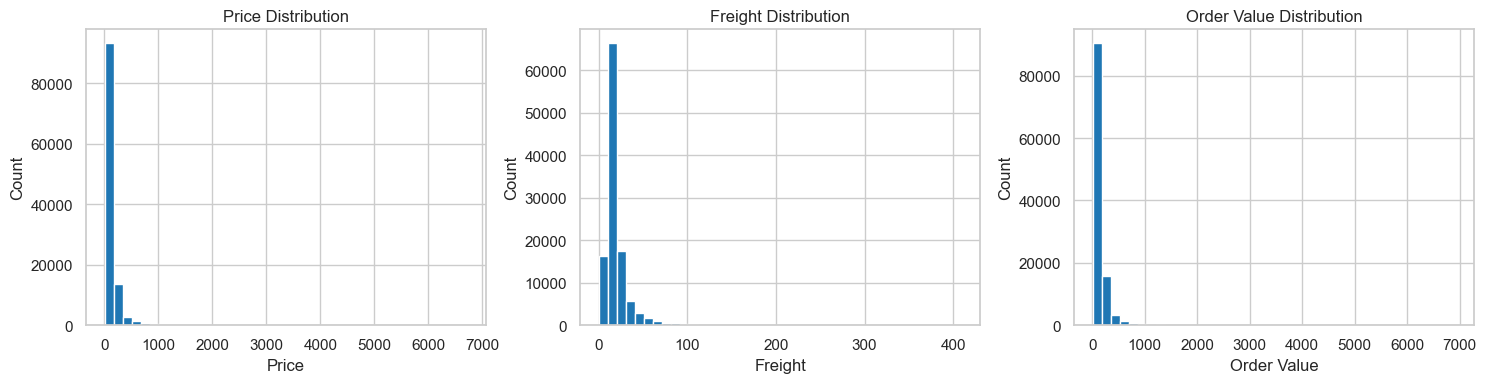

In [24]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
axes[0].hist(base['price'].dropna(), bins=40)
axes[0].set_title('Price Distribution'); axes[0].set_xlabel('Price'); axes[0].set_ylabel('Count')

axes[1].hist(base['freight_value'].dropna(), bins=40)
axes[1].set_title('Freight Distribution'); axes[1].set_xlabel('Freight'); axes[1].set_ylabel('Count')

axes[2].hist(base['order_value'].dropna(), bins=40)
axes[2].set_title('Order Value Distribution'); axes[2].set_xlabel('Order Value'); axes[2].set_ylabel('Count')
plt.tight_layout()
plt.show()

### 6.2 Bar Plot — Top Product Categories by Orders

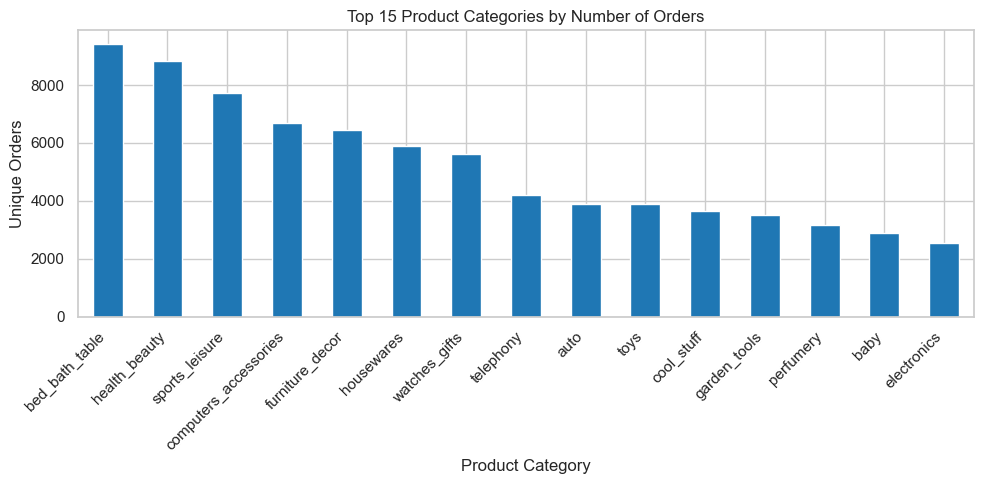

In [25]:
top_cats = (base.groupby('product_category_en')['order_id']
             .nunique()
             .sort_values(ascending=False)
             .head(15))

ax = top_cats.plot(kind='bar')
ax.set_title('Top 15 Product Categories by Number of Orders')
ax.set_xlabel('Product Category')
ax.set_ylabel('Unique Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 6.3 Box Plot — Price by Top Categories

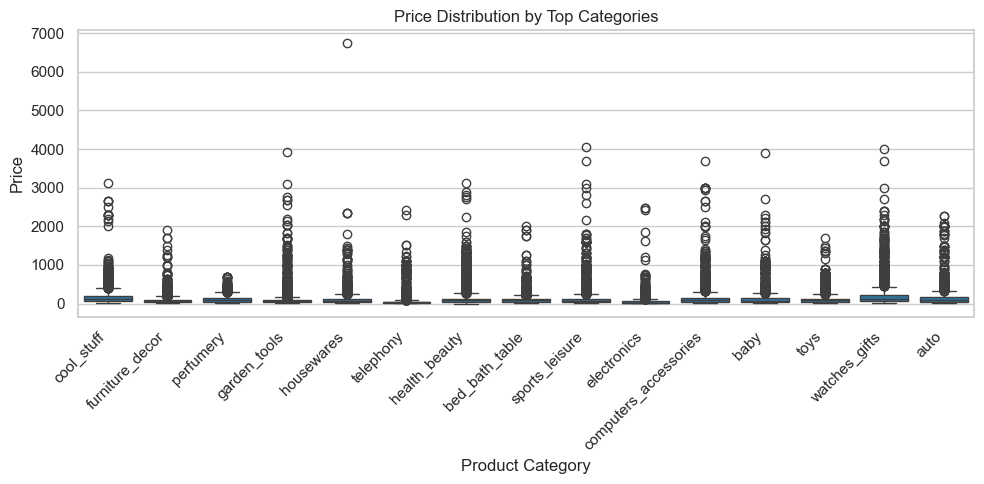

In [26]:
top_cat_names = top_cats.index.tolist()
subset = base[base['product_category_en'].isin(top_cat_names)]
sns.boxplot(data=subset, x='product_category_en', y='price')
plt.title('Price Distribution by Top Categories')
plt.xlabel('Product Category'); plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()

### 6.4 Scatter — Price vs Freight (relationship)

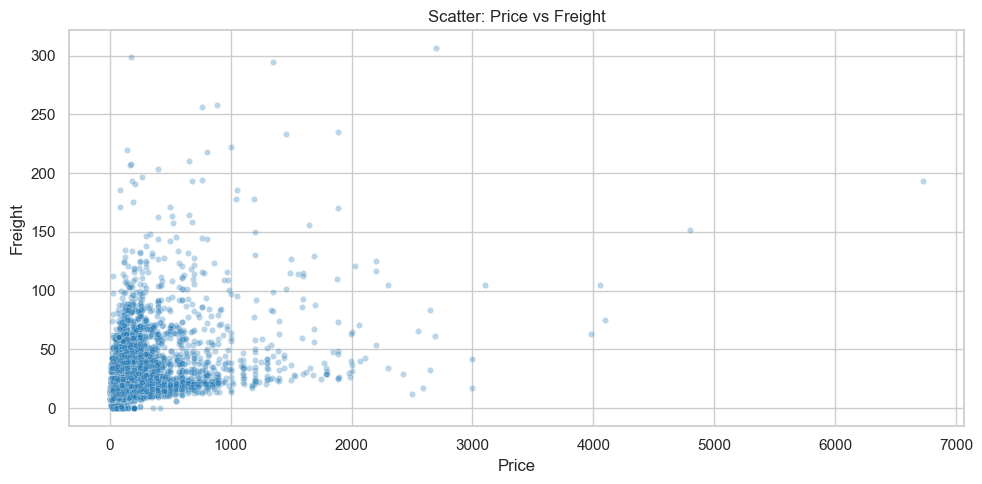

In [27]:
sns.scatterplot(data=base.sample(n=min(20000, len(base)), random_state=42), x='price', y='freight_value', alpha=0.3, s=20)
plt.title('Scatter: Price vs Freight'); plt.xlabel('Price'); plt.ylabel('Freight')
plt.tight_layout(); plt.show()

### 6.5 Correlation Heatmap (numeric features)

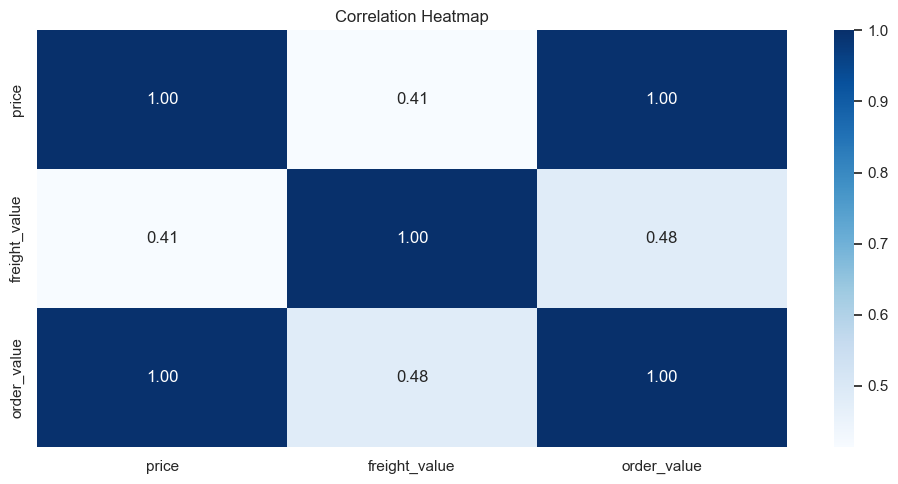

In [28]:
corr = base[['price','freight_value','order_value']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlation Heatmap')
plt.tight_layout(); plt.show()

## 7. Group Analysis & Pivot Tables
### 7.1 Group-by Examples

In [29]:
# Orders & revenue by category
grp_cat = base.groupby('product_category_en').agg(
    orders=('order_id','nunique'),
    items=('product_id','count'),
    revenue=('order_value','sum'),
    avg_order_value=('order_value','mean')
).sort_values('orders', ascending=False).head(20)
grp_cat

,orders,items,revenue,avg_order_value
product_category_en,,,,
bed_bath_table,9417,11115,1241681.72,111.712256
health_beauty,8836,9670,1441248.07,149.043234
sports_leisure,7720,8641,1156656.48,133.856785
computers_accessories,6689,7827,1059272.40,135.335684
furniture_decor,6449,8334,902511.79,108.292751
housewares,5884,6964,778397.77,111.774522
watches_gifts,5624,5991,1305541.61,217.917144
telephony,4199,4545,394883.32,86.883019
auto,3897,4235,685384.32,161.838092


## 8. Time‑Series Trends
Monthly orders and revenue trends using `order_purchase_timestamp`.

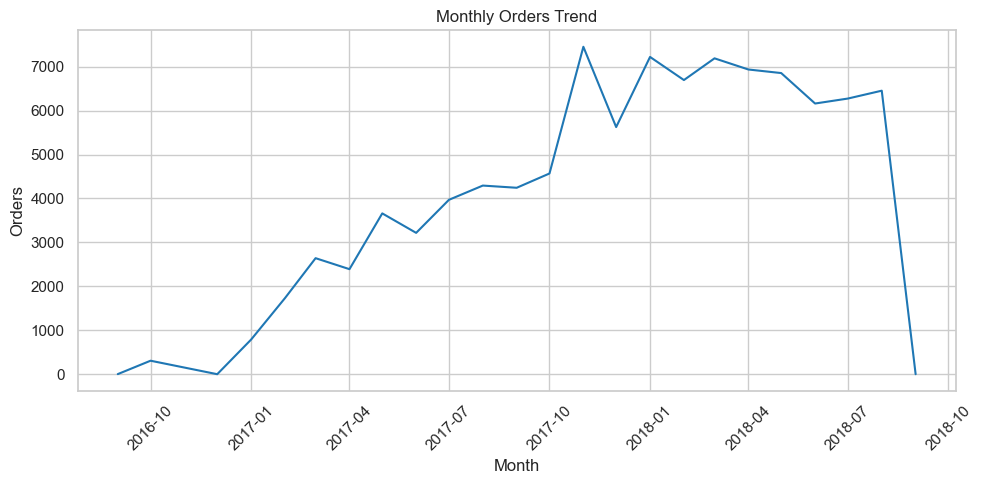

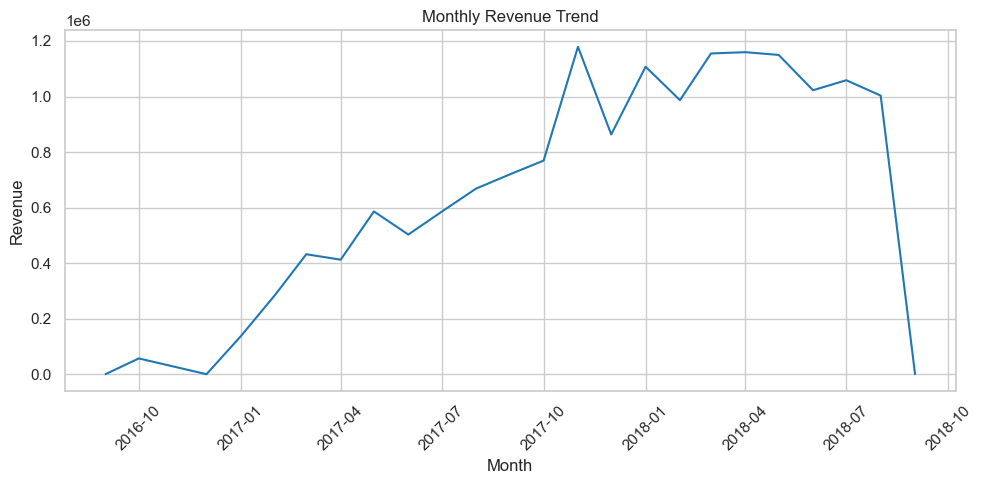

In [31]:
# Monthly trend: orders & revenue
monthly = (base
           .dropna(subset=['order_purchase_timestamp'])
           .assign(order_month=lambda d: d['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp())
           .groupby('order_month')
           .agg(orders=('order_id','nunique'), revenue=('order_value','sum'))
           .reset_index())

fig, ax = plt.subplots()
ax.plot(monthly['order_month'], monthly['orders'])
ax.set_title('Monthly Orders Trend'); ax.set_xlabel('Month'); ax.set_ylabel('Orders')
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

fig, ax = plt.subplots()
ax.plot(monthly['order_month'], monthly['revenue'])
ax.set_title('Monthly Revenue Trend'); ax.set_xlabel('Month'); ax.set_ylabel('Revenue')
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

## 9. Advanced Python Techniques
We explicitly include **lambda functions**, a **user-defined function**, and **list comprehensions** to meet the rubric.

In [32]:
# 9.1 Lambda: flag high-value orders
threshold = base['order_value'].quantile(0.9)
base['is_high_value'] = base['order_value'].apply(lambda v: 1 if v>=threshold else 0)
base['is_high_value'].value_counts()

is_high_value
0    101385
1     11265
Name: count, dtype: int64

In [33]:
# 9.2 User-defined function: bucketize order value
def value_bucket(v):
    if pd.isna(v): return 'unknown'
    if v < 50: return 'low'
    if v < 150: return 'medium'
    return 'high'

base['value_bucket'] = base['order_value'].apply(value_bucket)
base['value_bucket'].value_counts()

value_bucket
medium    58900
high      30438
low       23312
Name: count, dtype: int64

In [34]:
# 9.3 List comprehension: list numeric columns with missing values
num_missing_cols = [c for c in num_cols if base[c].isna().any()]
num_missing_cols

[]

## 10. Plot Polish & Annotations
All plots include titles and axis labels. Where helpful, we annotate short text insights.

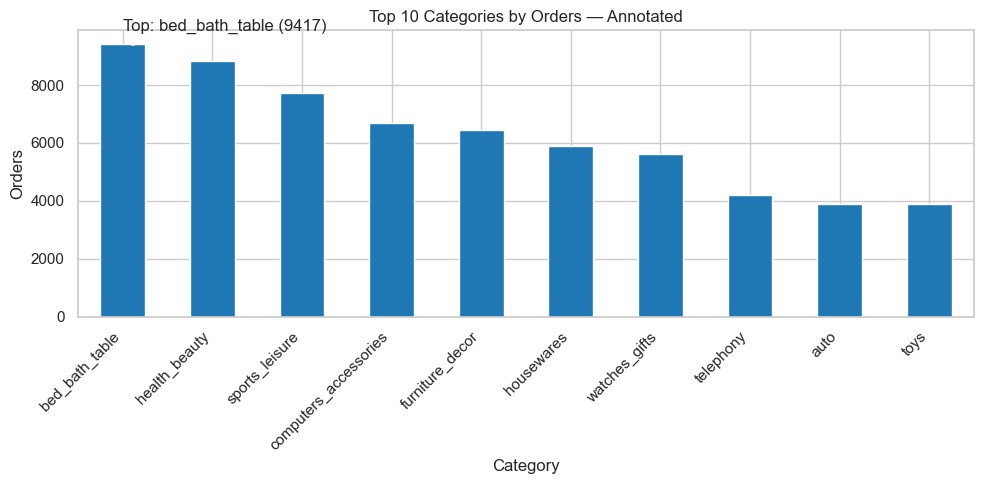

In [35]:
# Example: annotate a bar plot insight
ax = grp_cat['orders'].head(10).plot(kind='bar')
ax.set_title('Top 10 Categories by Orders — Annotated')
ax.set_xlabel('Category'); ax.set_ylabel('Orders')
top_name = grp_cat['orders'].idxmax()
top_val = int(grp_cat['orders'].max())
ax.annotate(f'Top: {top_name} ({top_val})', xy=(0, top_val), xytext=(0, top_val*1.05),
            arrowprops=dict(arrowstyle='->'))
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

## 11. Insights & Conclusions
**Key Findings (example bullets — refine after reviewing your plots):**
- A few **product categories dominate** order counts; however, **average order value** may be higher in niche categories.
- **Price and freight** show a **positive relationship** (higher-priced items tend to have higher freight).
- **Monthly trends** show distinct seasonality (peaks and troughs) — consider promo timing.
- **Payment type mix** varies by category; this may guide checkout UX and offers.
- High‑value orders (top 10%) cluster in specific categories; targeting can improve revenue.
